In [136]:
import numpy as np
from itertools import combinations
import re
from sklearn.metrics import pairwise_distances
import plotly.graph_objects as go
import plotly.figure_factory as ff
import cvxpy as cvx
from scipy.stats import bernoulli
from cvxpy import GUROBI as solverGUROBI
from gurobipy import *
import umap

class Frontera:
    """
    The Frontera class represents a frontier in a high-dimensional space and is used for feature extraction and dimensionality reduction. 
    It takes as input the data points (X), their corresponding labels (y), and parameters for defining the frontier 
    (percentil_min, percentil_max, and N_points_frontera).
    This class provides methods for calculating distances between points, as well as storing and managing information about categories, minimum distances, frontier points, and vectors.

    There are two methods available for dimensionality reduction: 'frontier_reduction' and 'prototypes'.
    'frontier_reduction': Finds the closest points that are aligned to the same direction vectors.
    'prototypes': Finds prototypes on the frontier that have the majority of the groups.

    Attributes:
    - X: Data points
    - y: Labels for data points
    - percentil_min: Minimum percentile for the frontier
    - percentil_max: Maximum percentile for the frontier
    - N_points_frontera: Number of points for the frontier
    - method: The dimensionality reduction method to use ('frontier_reduction' or 'prototypes')
    - dic_categorias: Dictionary for storing category information
    - dic_min_dst: Dictionary for storing minimum distances
    - list_dist_median: List for storing median distances
    - dic_categorias_UMAP: Dictionary for storing UMAP category information
    - dic_min_dst_UMAP: Dictionary for storing UMAP minimum distances
    - Frontier_Point_A_X: Dictionary for storing frontier points and their corresponding categories (A -> X)
    - Frontier_Point_X_A: Dictionary for storing frontier points and their corresponding categories (X -> A)
    - Frontier_Point: Dictionary for storing frontier points
    - Frontier_Vector: Dictionary for storing frontier vectors
    - class_vector: Dictionary for storing class vectors
    """
    def __init__(self, X, y, percentil_min, percentil_max, N_points_frontera, method='frontier_reduction'):
        self.X = X  # Data points
        self.y = y  # Labels for data points
        self.percentil_min = percentil_min  # Minimum percentile for the frontier
        self.percentil_max = percentil_max  # Maximum percentile for the frontier
        self.N_points_frontera = N_points_frontera  # Number of points for the frontier
        self.method = method  # Dimensionality reduction method ('frontier_reduction' or 'prototypes')
        # Dictionaries for storing category information and minimum distances
        self.dic_categorias = {}
        self.dic_min_dst = {}
        self.list_dist_median = []
        
        # Dictionaries for storing UMAP category information and minimum distances
        self.dic_categorias_UMAP = {}
        self.dic_min_dst_UMAP = {}
        
        # Dictionaries for storing frontier points and their corresponding categories
        self.Frontier_Point_A_X = {}
        self.Frontier_Point_X_A = {}
        
        # Dictionaries for storing frontier points, frontier vectors, and class vectors
        self.Frontier_Point = {}
        self.Frontier_Vector = {}
        self.class_vector = {}

        self._lambda = None
        self.c_w_ = None
        self.w_ = None
        self.X_1 = None
        self.y_1 = None
        self.lengthX = None
        self._epsilon = None
        self.lengthL = None
        self.label = None
        self.data_info = None
        # Variables for solving relaxed Integer Program.
        self.xi_n_lin = None
        self.alpha_j_lin = None
        self.opt_val = None
        # Variables for solving the Randomized Rounding Algorithm.
        self.prototype_length = None
        self.random_round_Sn = None
        self.random_round_Aj = None
        self.random_round_optimal_val = None        
        
    def distance(self, x0, x1):
        # This function calculates the pairwise squared Euclidean distance between two sets of points x0 and x1
        # The squared Euclidean distance between two points x and y in Euclidean space is given by the formula:
        # (x - y)^2 = x^2 - 2 * x * y + y^2
        
        # Calculate the pairwise squared Euclidean distance using the following steps:
        # 1. Compute the squared norms of x0 and x1: x0^2 and x1^2
        # 2. Compute the product of x0 and x1: x0 * x1
        # 3. Compute the pairwise distance matrix M_distance using the formula: x0^2 - 2 * x0 * x1 + x1^2
        
        M_distance = np.reshape(
            np.diag(np.dot(x0, x0.T)), (-1, 1)) - 2 * np.dot(x0, x1.T) + np.dot(np.ones((x0.shape[0], 1)), np.reshape(np.diag(np.dot(x1, x1.T)).T, (1, -1)))
        return M_distance
    def get_frontier(self):
        # Iterate through unique elements in self.y
        for i in np.unique(self.y): 
            # Create a dictionary with key format X_i and values being the corresponding X values when self.y is equal to i
            dic_categorias_aux = {'X_' + str(i): self.X[self.y == i]}
            # Update the main dictionary, self.dic_categorias
            self.dic_categorias.update(dic_categorias_aux)

        # Generate a list of all keys in self.dic_categorias
        categorias_list = [key for key in self.dic_categorias]
        # Generate all possible combinations of two categories
        comb_categories = combinations(categorias_list, 2)
        
        # Iterate through all category combinations
        for categories in list(comb_categories):
            # Calculate distance between the two categories using self.distance
            dist = self.distance(self.dic_categorias.get(categories[0]), self.dic_categorias.get(categories[1]))
            # Append median of the distance to self.list_dist_median
            self.list_dist_median.append(np.median(dist))

            # Calculate row-wise mean of the distance matrix
            row = np.mean(dist, axis=1)
            # Select indices of rows that are within the specified percentiles
            select_indices_row = np.where(
                (row > np.percentile(row, self.percentil_min)) & (row < np.percentile(row, self.percentil_max)))[0]
            # Get corresponding data points from the first category
            min_dst_row = self.dic_categorias.get(categories[0])[select_indices_row]
            # Update the self.dic_min_dst dictionary with the new values
            dic_min_dst_aux = {categories[0] + '_with_' + categories[1]: min_dst_row}
            self.dic_min_dst.update(dic_min_dst_aux)
            # Calculate column-wise mean of the distance matrix
            column = np.mean(dist, axis=0)
            # Select indices of columns that are within the specified percentiles
            select_indices_column = np.where(
                (column > np.percentile(column, self.percentil_min)) & (column < np.percentile(column, self.percentil_max)))[0]
            # Get corresponding data points from the second category
            min_dst_column = self.dic_categorias.get(categories[1])[select_indices_column]
            # Update the self.dic_min_dst dictionary with the new values
            dic_min_dst_aux = {categories[1] + '_with_' + categories[0]: min_dst_column}
            self.dic_min_dst.update(dic_min_dst_aux)

        # Generate a list of all keys in self.dic_min_dst
        list_all_frontier = [key for key in self.dic_min_dst]
        
        # Iterate through unique elements in self.y
        for i in np.unique(self.y):
            # Compile regex patterns for matching dictionary keys
            my_regex = r"^X_" + str(i)  # Regex pattern to match keys starting with "X_" and current element value
            p = re.compile(my_regex)   # Compile regex pattern
            list_A_with_X = [s for s in list_all_frontier if p.match(s)]  # Extract matching elements from list_all_frontier
            
            my_regex = r".*" + str(i) + r'$'  # Regex pattern to match keys ending with current element value
            p = re.compile(my_regex)   # Compile regex pattern
            list_X_with_A = [s for s in list_all_frontier if p.match(s)]  # Extract matching elements from list_all_frontier

            # Get the first elements in the lists
            mtz_A = self.dic_min_dst.get(list_A_with_X[0])  # Retrieve value from dic_min_dst using the first element in list_A_with_X
            mtz_X = self.dic_min_dst.get(list_X_with_A[0])  # Retrieve value from dic_min_dst using the first element in list_X_with_A
            
            # Concatenate remaining elements to mtz_A and mtz_X
            for j in range(1,len(list_A_with_X)):
                mtz_A = np.concatenate((mtz_A,self.dic_min_dst.get(list_A_with_X[j])), axis=0)
                mtz_X = np.concatenate((mtz_X,self.dic_min_dst.get(list_X_with_A[j])), axis=0)
                        
            # Create dictionaries to store updated values of mtz_A and mtz_X
            Front_Point_A_X ={'FrontPoints:(' + str(i) + ',X)' : mtz_A}    
            self.Frontier_Point_A_X.update(Front_Point_A_X)  # Update dictionary Frontier_Point_A_X with new values
            Front_Point_X_A ={'FrontPoints:(X,' + str(i) + ')' : mtz_X}    
            self.Frontier_Point_X_A.update(Front_Point_X_A)  # Update dictionary Frontier_Point_X_A with new values
            
    def centroid_regions(self):
        ## CALCULAR LOS CENTROIDES EN REGION DE FRONTERA
        
        # Loop through the dictionaries containing the frontier points
        for (key_A,value_A), (key_X,value_X) in zip(self.Frontier_Point_A_X.items(), self.Frontier_Point_X_A.items()):
            
            # Make copies of the dictionaries to avoid modifying the original dictionaries
            Point_A_X_copy = self.Frontier_Point_A_X.copy()
            Point_X_A_copy = self.Frontier_Point_X_A.copy()
            Front_Point = {}
            
            # Create a matrix to store the points and their coordinates
            points_matriz = np.zeros(shape=(self.N_points_frontera, self.X.shape[1]))
            
            # Iterate through the points on the frontier
            for i in range(0,self.N_points_frontera):
                
                # Calculate the distances between the A and X points
                dist = self.distance(Point_A_X_copy.get(key_A), Point_X_A_copy.get(key_X))
                
                # Find the indices of the minimum distance for row and column
                min_dist_A_with_X = np.where( dist==np.min(dist) )[0]
                min_dist_X_with_A = np.where( dist==np.min(dist) )[1]
                
                # Retrieve the A and X points with the minimum distance
                min_A_with_X = Point_A_X_copy.get(key_A)[min_dist_A_with_X]
                min_X_with_A = Point_X_A_copy.get(key_X)[min_dist_X_with_A]
                
                # Remove the selected points from the dictionaries
                Point_A_X_copy.update({ key_A: np.delete(Point_A_X_copy.get(key_A), min_dist_A_with_X, axis=0)})
                Point_X_A_copy.update({ key_X: np.delete(Point_X_A_copy.get(key_X), min_dist_X_with_A, axis=0)})
                
                # Calculate the centroid of the selected points and store it in the matrix
                point_value = (np.mean(min_A_with_X+min_X_with_A,axis=0))/2
                
                # Check for closeness with existing points and store only unique points
                if i != 0:
                    closeness_criterion = self.distance(np.reshape(point_value,(-1,self.X.shape[1])), points_matriz) < 0.8          #################
                    
                    if not np.any(closeness_criterion == True):
                        points_matriz[i] = point_value
                else:
                    points_matriz[i] = point_value
                
                # If one of the dictionaries is empty, exit the loop
                if (Point_A_X_copy.get(key_A).shape[0] == 0) or (Point_X_A_copy.get(key_X).shape[0] == 0):
                    break
            
            # Remove unused rows from the matrix
            row_points_matriz = np.sum(points_matriz, axis=1)
            select_indices_points_matriz = np.where( row_points_matriz != 0 )[0]
            points_matriz = points_matriz[select_indices_points_matriz]
            
            # Create a dictionary to store the frontier points
            Front_Point ={'Frontier:' + key_A.split(':')[1] : points_matriz}    
            self.Frontier_Point.update(Front_Point)  # Update the dictionary with the frontier points
        
    def calculate_vectors(self):
        # Loop through the categories and their associated frontier points
        for (key_region,region), (key_Frontier,Frontier_Point) in zip(self.dic_categorias.items(), self.Frontier_Point.items()):
            
            # Create a matrix to store the vectors
            Front_vector = {}
            n_row = 0
            vectors_matriz = np.zeros(shape=(self.Frontier_Point.get(key_Frontier).shape[0], self.X.shape[1]))
            
            # Iterate through the frontier points
            for key_Frontier in self.Frontier_Point.get(key_Frontier):

                # Calculate the distances between the category and the frontier point
                dist = self.distance(self.dic_categorias.get(key_region), np.reshape(key_Frontier,(-1,self.X.shape[1])) ) 

                # Find the indices of the minimum distance
                min_dist_A_with_B = np.where( dist <= 2)[0]      #################
                
                # Retrieve the category points with the minimum distance
                min_A_with_B = self.dic_categorias.get(key_region)[min_dist_A_with_B]        
                
                # Calculate the vector and store it in the matrix
                vector_value = np.median(min_A_with_B,axis=0)
                vectors_matriz[n_row] = vector_value
            
                n_row += 1
            
            # Create a dictionary to store the vectors for the current frontier
            Front_vector ={'Vec_Frontier:(X,' + key_region.split('_')[-1] + ')' : vectors_matriz}    
            self.Frontier_Vector.update(Front_vector) 
            
        # Loop through the frontier points and their associated vectors
        for (key_origin,value_origin), (key_vec,value_vector) in zip(self.Frontier_Point.items(), self.Frontier_Vector.items()):
            
            # Calculate the class vector by subtracting the frontier point from the vector
            vector_aux = np.concatenate((value_origin,value_vector-value_origin), axis=1)
            class_vec = {'Class_vector:' + key_vec.split(':')[1] : vector_aux}
            self.class_vector.update(class_vec)
    def filter_vector(self):
        # Combine all frontier points into a single matrix
        mtz_origin = self.Frontier_Point.get([key for key in self.Frontier_Point][0])
        for j in range(1, len(self.Frontier_Point)):
            mtz_origin = np.concatenate((mtz_origin, self.Frontier_Point.get([key for key in self.Frontier_Point][j])), axis=0)

        # Calculate distance matrix between all frontier points and replace diagonal with max distance
        dist_mtz_origin = self.distance(mtz_origin, mtz_origin)
        dis_max = np.max(dist_mtz_origin)
        indent_max = np.nan_to_num(np.identity(dist_mtz_origin.shape[0]) * dis_max)
        dist_mtz_origin = (dist_mtz_origin + indent_max)

        # Create a boolean matrix for distances less than 2
        mtz_bool_eucl = dist_mtz_origin < 2

        # Combine all class vectors into a single matrix
        mtz_vec = self.class_vector.get([key for key in self.class_vector][0])
        for j in range(1, len(self.class_vector)):
            mtz_vec = np.concatenate((mtz_vec, self.class_vector.get([key for key in self.class_vector][j])), axis=0)
        mtz_vec = mtz_vec[:, self.X.shape[1]:]

        # First filter: filter by cosine distance
        dist_cosine = 1 - pairwise_distances(mtz_vec, metric="cosine")
        mtz_bool_cos = dist_cosine <= -0.9

        # Create an upper triangular boolean matrix
        diag = np.triu(np.ones(dist_mtz_origin.shape), 1).T == 1

        # Filter points based on boolean matrices and the upper triangular matrix
        regla = mtz_bool_cos & mtz_bool_eucl & diag
        select_indices_1 = np.where(regla == True)[0]

        # Update origin and vectors based on first filter
        origin_redu = mtz_origin[select_indices_1]
        vec_redu = mtz_vec[select_indices_1]

        # Update dictionaries with reduced frontier points and vectors
        self.Frontier_Point.update({'Frontier: Reduct': origin_redu})
        self.Frontier_Vector.update({'Vec_Frontier: Reduct': vec_redu + origin_redu})
        self.class_vector.update({'Class_vector_Reduct:': np.concatenate((origin_redu, vec_redu), axis=1)})

        # Second filter: filter by cosine distance again
        dist_cosine_2 = 1 - pairwise_distances(vec_redu, metric="cosine")
        mtz_bool_cos_2 = dist_cosine_2 <= 0.8

        # Create an upper triangular boolean matrix
        diag_2 = np.triu(np.ones(dist_cosine_2.shape), 1).T == 1

        # Filter points based on boolean matrices and the upper triangular matrix
        regla_2 = mtz_bool_cos_2 & diag_2
        select_indices_1_1 = np.where(regla_2 == True)[0]

        # Update origin and vectors based on second filter
        origin_redu_2 = origin_redu[select_indices_1_1]
        vec_redu_2 = vec_redu[select_indices_1_1]

        # Update dictionaries with fully reduced frontier points and vectors
        Front_Point = {'Frontier: Full Reduct': origin_redu_2}
        self.Frontier_Point.update(Front_Point)
        Front_vector ={'Vec_Frontier: Full Reduct' : vec_redu_2+origin_redu_2}    
        self.Frontier_Vector.update(Front_vector) 
        class_vec = {'Class_vector_Full_Reduct:': np.concatenate((origin_redu_2,vec_redu_2), axis=1)}
        self.class_vector.update(class_vec) 
        self.color_list = [0] * len(self.dic_categorias.keys())
        for i in range( len(self.dic_categorias.keys()) ):
            self.color_list[i] = np.random.randint(0, 1000)
#    --------------------------------------------------------------------
    def get_X1_Y1(self):
        """
        Extracts X_1 and y_1 arrays based on the Frontier_Point_A_X attribute.

        Returns
        -------
        X_1 : numpy array
            Array containing the data points corresponding to the frontier points.
        y_1 : numpy array
            Array containing the labels corresponding to the frontier points.
        """
        X_1 = []
        y_1 = []
        for key, value in self.Frontier_Point_A_X.items():
            for point in value:
                X_1.append(point)
                y_1.append(int(''.join(filter(str.isdigit, key.split(':')[1]))))
        self.X_1 = np.array(X_1)
        self.y_1 = np.array(y_1)
        self._epsilon = np.percentile(self.X_1[:, 1], 5)
        #np.percentile(self.X_1[:, 1], 25)
        #self.X_1[:,1].mean().astype(float)
        #(X_1.mean()) #assigne the mean of the distances to _epsilon
    def labelsInfo(self):
        """ Extracts the unique class label from the data X.

            Attributes
            ----------
            self.label : set 
                Stores unique class labels.

            Returns
            -------
            set of class labels.
        """
        self.label = set(self.y_1)
        return self.label

    def getNumLabel(self):
        """ Extracts the length of the class labels.

            Attributes
            ----------
            self.lengthL : int
                length of the class labels.
            
            Returns
            -------
            self.length : int
                length of the class labels.
           
        """
        self.lengthL = len(self.label)
        return self.lengthL 

    def dataInfo(self, label):
        """Creates a data dictionary according to the class label passed as argument label.

            Parameter
            ---------
            label: int
                contains the label number.

            Attributes
            ----------
            indexes: list[int]
                indices, where label is equal to the class label of the data.
            X_l: data
                subset of the training data with indexes as index.
            y_l: data
                class label of the data X_l.
            size_l: int
                length of the data with the same label.
            indexes_not_l: list[int]
                indices, where label is not equal to the class label of the data.
            X_not_l: data
                subset of data where the label is not equal to the class label.
            y_not_l: data
                contains the label which is not equal to the label.
            size_not_l: list[int]
                length of the data which is not of the same label.
            data: dict
                contains the data where argument label is equal to the class label.
            
            Returns
            -------
            data: data dictionary containing data with class label equal to label and class label not
                equal to label.
        """
        indexes = [idx for idx, lbl in enumerate(self.y_1) if lbl == label]
        X_l = self.X_1[indexes]
        y_l = self.y_1[indexes]
        size_l = X_l.shape[0]
        indexes_not_l = [idx for idx, lbl in enumerate(self.y_1) if lbl != label]
        X_not_l = self.X_1[indexes_not_l]
        y_not_l = self.y_1[indexes_not_l]
        size_not_l = X_not_l.shape[0]
        data = {
            "X_l": X_l,
            "y_l": y_l,
            "indices_l": indexes,
            "size_l": size_l,
            "X_not_l": X_not_l,
            "y_not_l": y_not_l,
            "indices_not_l": indexes_not_l,
            "size_not_l": size_not_l,
        }
        return data

    def checkNeighborhood(self, x_1, x_2):
        """ Checks if a point is in the epsilon ball or if a point 'x_test' is in the epsilon neighborhood of a
            point 'x'.
        
            Parameter
            ---------
            x_1: vector
                center of the epsilon ball.
            x_2: vector
                point to be checked if it lies in the ball with radius epsilon or not.
            
            Attribute
            ---------
                result: bool
                    Checks if the point is in neighbourhood or not.
            
            Returns
            -------
                True, if a point lies in the neighborhood of epsilon ball centered around parameter
                x otherwise, returns False.
        """
        result = np.linalg.norm((x_1 - x_2), ord=2, keepdims=True) <= self._epsilon
        return result

    def calculate_Clj(self, label):
        """ Calculates the total number of data samples(with different label) if it comes in the epsilon 
            neighborhood of a point if a point is chosen as a prototype.

            Parameter 
            ---------
            label: int
                contains a class label.
            
            Attributes
            ----------
            data: dict
                contains the data dictionary according to the argument label.
            X_l: Any
                contains the data with same class label.
            X_not_l: Any
                contains the data where label is not equal to class label.
            sets_C_lj: list[int]
                contains number of points covered where, class label is not equal to true label if x_jl is
                considered as prototype.
            
            Returns
            -------
            Cost of adding a point.
        """
        data = self.dataInfo(label=label)
        X_l = data["X_l"]
        X_not_l = data["X_not_l"]
        sets_C_lj = []
        for x_jl in X_l:
            temp = 0
            for x_no_l in X_not_l:
                if self.checkNeighborhood(x_jl, x_no_l):
                    temp += 1
            sets_C_lj.append(temp)
        C_lj = [(self._lambda + set_C_lj) for set_C_lj in sets_C_lj]
        data["C_lj"] = np.array(C_lj)
        return data

    def checkCoverPoints(self, label):
        """ Checks for neighborhood points, if a point is in the ball with radius epsilon(for the
            chosen data as a prototype) then, the value for that index is 1 else it is zero.

            Parameter
            ---------
            label: int
                Contains a class label.

            Attributes
            ----------
            X_l: data
                subset of the training data with indexes as index.
            size_l: int
                length of the data with the same label.
            constraint_matrix: int
                size_l X size_l matrix which contains the neighborhood information.

            Returns
            -------
            data:  updates the data dictionary with pairwise neighborhood information.
        """
        data = self.calculate_Clj(label=label)
        X_l = data["X_l"]
        size_l = data["size_l"]
        constraint_matrix = np.zeros(shape=(size_l, size_l))
        for x_nl in range(size_l):
            for x_jl in range(size_l):
                if self.checkNeighborhood(X_l[x_jl], X_l[x_nl]):
                    constraint_matrix[x_nl][x_jl] = 1
        data["constraint_matrix"] = constraint_matrix
        return data

    def fit(self):
        """ Here the model is trained according to the class label using convex optimisation method.
            Attributes are added to the data dictionary for Randomized rounding algorithm for optimal
            parameters. 

            Attributes
            ----------
            train_X: M x N matrix
                Training data set.
            train_y: M x 1 vector
                Class label of the training data set.
            label: int
                contains set of unique labels.
            alpha_j_lin: vector
                stores the alpha value after optimisation.
            xi_n_lin: vector
                stores Xi value after optimisation.
            opt_val_lin: list
                contains the optimal value of the Objective function.
            update_data_info:
                updates the data dictionary with the attributes above.
        """
        self.lengthX = len(self.X_1)
        self._lambda = 1/ self.lengthX
        label = self.labelsInfo()
        alpha_j_lin = np.zeros(shape=self.lengthX)
        xi_n_lin = np.zeros(shape=self.lengthX)
        opt_val_lin = []
        update_data_info = []

        solverGUROBI = cvx.GUROBI

        for lbl in label:
            data = self.checkCoverPoints(label=lbl)
            size_l = data["size_l"]
            C_lj = data["C_lj"]
            alpha_jl = cvx.Variable(shape=size_l)
            xi_nl = cvx.Variable(shape=size_l)
            constraint_matrix = data["constraint_matrix"]
            zero_vec = np.zeros(shape=size_l)
            one_vec = np.ones(shape=size_l)
            # Objective function for minimisation.
            objective = cvx.Minimize((C_lj @ alpha_jl) + sum(xi_nl))
            # Constraints for the minimisation.
            constraints = [(constraint_matrix @ alpha_jl >= (one_vec - xi_nl)),
                           alpha_jl >= zero_vec,
                           alpha_jl <= one_vec,
                           xi_nl >= zero_vec]

            prob = cvx.Problem(objective, constraints)
            prob.solve(solver=solverGUROBI)

            data["alpha_jl_lp"] = [1 if alpha_jl >= 1 else alpha_jl for alpha_jl in alpha_jl.value]
            data["alpha_jl_lp"] = [0 if alpha_jl <= 0 else alpha_jl for alpha_jl in data["alpha_jl_lp"]]
            data["xi_nl_lp"] = [1 if xi_nl >= 1 else xi_nl for xi_nl in xi_nl.value]
            data["xi_nl_lp"] = [0 if xi_nl <= 0 else xi_nl for xi_nl in data["xi_nl_lp"]]

            first_term = sum([(c_lj * alpha_jl) for c_lj, alpha_jl in zip(data["C_lj"], data["alpha_jl_lp"])])
            second_term = sum(data["xi_nl_lp"])
            # calculate the optimal value after the optimisation.
            optimal_l = first_term + second_term

            data["optimal_l_lp"] = optimal_l
            opt_val_lin.append(optimal_l)
            update_data_info.append(data)

            indices_l = data["indices_l"]
            for idx in indices_l:
                alpha_j_lin[idx] = alpha_jl.value[indices_l.index(idx)]
                xi_n_lin[idx] = xi_nl.value[indices_l.index(idx)]

        self.alpha_j_lin = alpha_j_lin
        self.xi_n_lin = xi_n_lin
        self.opt_val = sum(opt_val_lin)
        self.data_info = update_data_info
        self.objectiveValue()

    def objectiveValue(self):
        """ Here Randomized Rounding Algorithm is performed to recover the integer values we need 
            for our indicator variable, we choose to round our optimal variables of the linear program.

            Attributes
            ----------
            data_info:

            label:
                 contains set of unique labels.
            random_round_Aj:

            random_round_Sn:
            random_round_optimal_value:
            update_data_info:
        """
        data_info = self.data_info
        label = self.labelsInfo()
        random_round_Aj = np.zeros(shape=self.lengthX)
        random_round_Sn = np.zeros(shape=self.lengthX)
        random_round_optimal_value = []
        update_data_info = []
        for lbl in label:
            data = data_info[lbl]
            size_l = data["size_l"]
            temp_random_round_Ajl = np.zeros(shape=size_l, dtype=int)
            temp_random_round_Snl = np.zeros(shape=size_l, dtype=int)
            temp_optimal_round = float('nan')
            C_lj = data["C_lj"]
            alpha_jl_lp = data["alpha_jl_lp"]
            xi_nl_lp = data["xi_nl_lp"]
            optimal_l_lp = data["optimal_l_lp"]
            optimal_l_log = 2 * np.log (size_l) * optimal_l_lp
            repeat = True
            while repeat:
                temp_random_round_Ajl = np.zeros(shape=size_l, dtype=int)
                temp_random_round_Snl = np.zeros(shape=size_l, dtype=int)

                for l in range(int(np.ceil(2 * np.log(size_l)))):
                    for j in range(size_l):
                        temp_round_Ajl = bernoulli.rvs(alpha_jl_lp[j])
                        temp_random_round_Ajl[j] = max(temp_round_Ajl, temp_random_round_Ajl[j])
                        temp_round_Snl = bernoulli.rvs(xi_nl_lp[j])
                        temp_random_round_Snl[j] = max(temp_round_Snl, temp_random_round_Snl[j])

                constraint_matrix = data["constraint_matrix"]
                first_term = sum([c_lj * A_jl for c_lj, A_jl in zip(C_lj, temp_random_round_Ajl)])
                second_term = sum(temp_random_round_Snl)
                temp_optimal_round = first_term + second_term

                get_val_Ajl = constraint_matrix @ temp_random_round_Ajl
                get_val_Sn = 1 - temp_random_round_Snl
                if all ([lhs >= rhs for lhs, rhs in zip(get_val_Ajl, get_val_Sn)]):
                    if all ([(A_jl == 0 or A_jl == 1) for A_jl in temp_random_round_Ajl]):
                        if all ([S_nl >= 0 for S_nl in temp_random_round_Snl]):
                            if temp_optimal_round <= optimal_l_log:
                                repeat = False

            data["random_round_Ajl"] = temp_random_round_Ajl
            data["random_round_Snl"] = temp_random_round_Snl
            data["optimal_val_random"] = temp_optimal_round
            random_round_optimal_value.append(temp_optimal_round)
            update_data_info.append(data)

            indices_l = data["indices_l"]
            for idx in indices_l:
                random_round_Aj[idx] = temp_random_round_Ajl[indices_l.index(idx)]
                random_round_Sn[idx] = temp_random_round_Snl[indices_l.index(idx)]

        self.random_round_Aj = random_round_Aj
        self.random_round_Sn = random_round_Sn
        self.random_round_optimal_val = sum(random_round_optimal_value)

        self.w_ = [x for x, A_j in zip(self.X, self.random_round_Aj) if A_j == 1]
        self.w_ = np.array (self.w_)

        self.c_w_ = [y for y, A_j in zip(self.y, self.random_round_Aj) if A_j == 1]
        self.prototype_length = self.w_.shape[0]
        self.data_info = update_data_info

# prototypes = proto_selector.w_
# prototype_labels = proto_selector.c_w_
  
    def frontier(self): 
        if self.method == 'frontier_reduction':
            self.get_frontier()
            self.centroid_regions()
            self.calculate_vectors()
            self.filter_vector()
        elif self.method == 'prototypes':
            self.get_frontier()
            self.get_X1_Y1()
#            self.labelsInfo()
#            self.getNumLabel()
#            self.dataInfo()
#            self.checkNeighborhood()
#            self.calculate_Clj()
#            self.checkCoverPoints()
            self.fit()
#            self.objectiveValue()
        else:
            raise ValueError("Invalid method specified")
    # def frontier(self):
    #     self.get_frontier()
    #     self.centroid_regions()
    #     self.calculate_vectors()
    #     self.filter_vector()
    def plot_muestra_2D(self, col_1, col_2, include_layout=True):
        # Set initial state for the loop
        door = True
        next_color = 0

        # Loop through the categories in the dictionary
        for key, value in self.dic_categorias.items():
            # If it's the first iteration, create a new plot with the first category's data
            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                                 mode='markers',
                                                 name=key,
                                                 marker=dict(
                                                     size=6,
                                                     # Set color to an array/list of desired values
                                                     # color=self.color_list[next_color],
                                                     colorscale='picnic',  # Choose a colorscale
                                                     opacity=0.7)
                                                 )])
                # Change the door variable to False, indicating that the first iteration is done
                door = False
                # Increment the color index
                next_color += 1
            else:
                # For the rest of the categories, add them to the existing plot
                fig.add_trace(go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                         mode='markers',
                                         name=key,
                                         marker=dict(
                                             size=6,
                                             # Set color to an array/list of desired values
                                             # color=self.color_list[next_color],
                                             colorscale='picnic',  # Choose a colorscale
                                             opacity=0.7)
                                         ))
                # Increment the color index
                next_color += 1

        # If the include_layout parameter is True, update the layout properties of the plot
        if include_layout:
            fig.update_layout(
                autosize=False,
                width=600,
                height=600,
                margin=dict(l=0, r=0, b=0, t=10))

            # Display the plot
            fig.show()
    def plot_frontera_2D(self, col_1, col_2):
        # Set initial state for the loop
        door = True
        next_color = 0

        # Loop through the categories in the dictionary
        for key, value in self.dic_categorias.items():
            # If it's the first iteration, create a new plot with the first category's data
            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                                 mode='markers',
                                                 name=key,
                                                 marker=dict(
                                                     size=6,
                                                     # Set color to an array/list of desired values
                                                     # color=self.color_list[next_color],
                                                     colorscale='picnic',  # Choose a colorscale
                                                     opacity=0.7)
                                                 )])
                # Change the door variable to False, indicating that the first iteration is done
                door = False
                # Increment the color index
                next_color += 1
            else:
                # For the rest of the categories, add them to the existing plot
                fig.add_trace(go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                         mode='markers',
                                         name=key,
                                         marker=dict(
                                             size=6,
                                             # Set color to an array/list of desired values
                                             # color=self.color_list[next_color],
                                             colorscale='picnic',  # Choose a colorscale
                                             opacity=0.7)
                                         ))
                # Increment the color index
                next_color += 1

        # Loop through the dictionaries containing frontier points and add them to the plot
        for point_dict in [self.Frontier_Point_A_X, self.Frontier_Point_X_A, self.Frontier_Point]:
            for key, value_dst in point_dict.items():
                # Configure the marker symbol and size based on the dictionary being processed
                if point_dict == self.Frontier_Point:
                    symbol = 300
                    size = 50
                else:
                    symbol = 220
                    size = 14

                # Add the frontier points to the plot
                fig.add_trace(go.Scatter(x=value_dst[:, col_1], y=value_dst[:, col_2],
                                         mode='markers',
                                         name=key,
                                         marker=dict(
                                             symbol=symbol,
                                             size=size,
                                             color=np.random.randint(100),  # Set color to a random integer value
                                             # colorscale='Viridis',  # Choose a colorscale
                                             opacity=1)
                                         ))

        # Update the layout properties of the plot
        fig.update_layout(
            autosize=True,
            width=1200,
            height=750,
            margin=dict(l=10, r=10, b=10, t=20))

        # Display the plot
        fig.show()
    def plot_Vectors(self, col_1, col_2):
        # Set initial state for the loop
        door = True
        next_color = 0

        # Loop through the categories in the dictionary
        for key, value in self.dic_categorias.items():
            # If it's the first iteration, create a new plot with the first category's data
            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                                 mode='markers',
                                                 name=key,
                                                 marker=dict(
                                                     size=6,
                                                     # Set color to an array/list of desired values
                                                     # color=self.color_list[next_color],
                                                     colorscale='picnic',  # Choose a colorscale
                                                     opacity=0.7)
                                                 )])
                # Change the door variable to False, indicating that the first iteration is done
                door = False
                # Increment the color index
                next_color += 1
            else:
                # For the rest of the categories, add them to the existing plot
                fig.add_trace(go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                         mode='markers',
                                         name=key,
                                         marker=dict(
                                             size=6,
                                             # Set color to an array/list of desired values
                                             # color=self.color_list[next_color],
                                             colorscale='picnic',  # Choose a colorscale
                                             opacity=0.7)
                                         ))
                # Increment the color index
                next_color += 1

        # Loop through the dictionaries containing frontier points and vectors
        for point_dict, symbol, size in zip([self.Frontier_Point, self.Frontier_Vector], [300, 2], [50, 15]):
            for key, value_dst in point_dict.items():
                # Add the points or vectors to the plot
                fig.add_trace(go.Scatter(x=value_dst[:, col_1], y=value_dst[:, col_2],
                                         mode='markers',
                                         name=key,
                                         marker=dict(
                                             symbol=symbol,
                                             size=size,
                                             color=np.random.randint(100),  # Set color to a random integer value
                                             # colorscale='Viridis',  # Choose a colorscale
                                             opacity=1)
                                         ))

        # Loop through the class vectors and create quiver plots
        for key, value in self.class_vector.items():
            # Calculate the midpoints for the u and v components of the quiver plot
            col_1_ = int(col_1 + value.shape[1] / 2)
            col_2_ = int(col_2 + value.shape[1] / 2)

            # Create a quiver plot for the class vector
            quiver_fig = ff.create_quiver(x=value[:, col_1], y=value[:, col_2],
                                          u=value[:, col_1_], v=value[:, col_2_],
                                          scale=1,
                                          arrow_scale=.3,
                                          name=key,
                                          line_width=1.5)

            # Add the quiver plot to the main plot
            fig.add_traces(data=quiver_fig.data)

        # Update the layout properties of the plot
        fig.update_layout(
            autosize=True,
            width=1200,
            height=750,
            margin=dict(l=10, r=10, b=10, t=20))

        # Display the plot
        fig.show()
    def plot_UMAP(self):
        # Perform UMAP dimensionality reduction on the data
        trans = umap.UMAP(random_state=42).fit(self.X)
    
        # Transform the original data points and store them in a new dictionary
        for key, value in self.dic_categorias.items():
            value_UMAP = trans.transform(value)
            dic_categorias_aux = {key: value_UMAP}
            self.dic_categorias_UMAP.update(dic_categorias_aux)
    
        # Transform the minimum distance points and store them in a new dictionary
        for key, value in self.dic_min_dst.items():
            value_UMAP = trans.transform(value)
            dic_min_dst_aux = {key: value_UMAP}
            self.dic_min_dst_UMAP.update(dic_min_dst_aux)
    
        # Set initial state for the loop
        door = True
        next_color = 0
    
        # Loop through the categories in the UMAP transformed dictionary
        for key, value in self.dic_categorias_UMAP.items():
            # If it's the first iteration, create a new plot with the first category's data
            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, 0], y=value[:, 1],
                                                 mode='markers',
                                                 name=key,
                                                 marker=dict(
                                                     size=6,
                                                     # color=self.color_list[next_color],  # Set color to an array/list of desired values
                                                     colorscale='picnic',  # Choose a colorscale
                                                     opacity=0.7)
                                                 )])
                # Change the door variable to False, indicating that the first iteration is done
                door = False
                # Increment the color index
                next_color += 1
            else:
                # For the rest of the categories, add them to the existing plot
                fig.add_trace(go.Scatter(x=value[:, 0], y=value[:, 1],
                                         mode='markers',
                                         name=key,
                                         marker=dict(
                                             size=6,
                                             # color=self.color_list[next_color],  # Set color to an array/list of desired values
                                             colorscale='picnic',  # Choose a colorscale
                                             opacity=0.7)
                                         ))
                # Increment the color index
                next_color += 1
    
        # Loop through the minimum distance points dictionary and add them to the plot
        for key, value_dst in self.dic_min_dst_UMAP.items():
            fig.add_trace(go.Scatter(x=value_dst[:, 0], y=value_dst[:, 1],
                                     mode='markers',
                                     name=key,
                                     marker=dict(
                                         symbol=220,
                                         size=14,
                                         color=np.random.randint(100),  # Set color to an array/list of desired values
                                         # colorscale='Viridis',  # Choose a colorscale
                                         opacity=1)
                                     ))
    
        # Update the layout properties of the plot
        fig.update_layout(
            autosize=True,
            width=800,
            height=600,
            margin=dict(l=10, r=10, b=10, t=20))
    
        # Display the plot
        fig.show()

In [137]:
import scipy.stats as stats

import pandas as pd
from sklearn.datasets import make_blobs

import plotly.graph_objects as go

import matplotlib.pyplot as plt # Para crear gráficos con matplotlib
import plotly as py
import plotly.io as pio

In [138]:
pio.renderers.default = 'iframe'

In [139]:
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
        n_samples    = 600, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 1, 
        shuffle      = True, 
        random_state = 0
       )

In [140]:
fig = go.Figure(data=[go.Scatter(x=X[:, 0], y=X[:, 1],
                                   mode='markers', 
                                   marker=dict(
                                    size=6,
                                    color=y,                # set color to an array/list of desired values
                                    colorscale='picnic',   # choose a colorscale
                                    opacity=0.7)
                                  )])

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=0, r=0, b=0, t=10))
    
fig.show()

In [164]:
frontera = Frontera(X,y,percentil_min=5, percentil_max=20, N_points_frontera=41)

In [165]:
frontera.frontier()

In [166]:
frontera = Frontera(X,y,percentil_min=5, percentil_max=20, N_points_frontera=41, method='prototypes')

In [167]:
frontera.frontier()

In [168]:
frontera.X.shape

(600, 2)

In [169]:
frontera.X_1.shape

(180, 2)

In [171]:
frontera._epsilon

1.0626216249912652

In [172]:
frontera.c_w_

[2, 1, 0, 2, 0, 0]

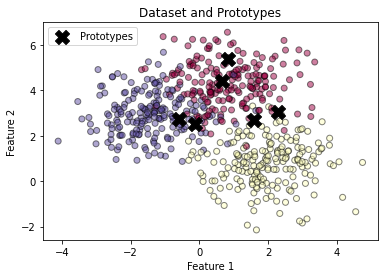

In [173]:
# Get the selected prototypes and their labels
prototypes = frontera.w_
prototype_labels = frontera.c_w_

# Plot the data points and prototypes
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Spectral, alpha=0.5)
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='black', marker='X', s=200, label='Prototypes')

# Customize the plot
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Dataset and Prototypes')

# Show the plot
plt.show()